In [1]:
"""This script is meant to calculate estimated cost and likelihood of 
enhancing items with assumed success rates and failure rates.
The method will be to run a simulation and return plots
of expected results. This script will use rates for ilevel 150."""

import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from __future__ import division
from numpy.random import rand

# Uploaded to github 8/7/15
#Optionally use the user inputs
#print 'Enhancement costs are for level 150 equips'
#superior = raw_input('Is the item superior? (Yes/No) ')
#enhance_to = raw_input('Enhancing to how many stars? ')
#trials = raw_input('How many trials per star? ')

In [2]:
enh_rates = pd.read_csv('EnhancementRates.csv')

In [3]:
enh_rates['Success%'] = enh_rates['Success rate']/100
enh_rates['Fail_stay%'] = enh_rates['Failure (stay)']/100
enh_rates['Fail_dec%'] = enh_rates['Failure (decrease)']/100
enh_rates['Fail_boom%'] = enh_rates['Failure (boom)']/100

In [4]:
enh_rates.head()

,Stars,Success rate,Failure (stay),Failure (decrease),Failure (boom),Superior,Cost,Region,Success%,Fail_stay%,Fail_dec%,Fail_boom%
0,0,95,5,0,0,no,136000,EU,0.95,0.05,0,0
1,1,90,10,0,0,no,271000,EU,0.90,0.10,0,0
2,2,85,15,0,0,no,406000,EU,0.85,0.15,0,0
3,3,85,15,0,0,no,541000,EU,0.85,0.15,0,0
4,4,80,20,0,0,no,676000,EU,0.80,0.20,0,0


In [5]:
def create_trials_table(trials,superior,enhance_to,enh_rates,region):
    results = DataFrame(index=np.arange(trials),columns=['Trial','Cost','Stars','Status'])
    for trial in range(trials):
        stars = 0
        total_cost = 0
        free_pass = 0
        status = 'Exists'
        while (stars < enhance_to):
            random = rand()
            row = enh_rates.loc[(enh_rates['Stars'] == stars) & (enh_rates['Superior'] == superior) & (enh_rates['Region'] == region)]
            success_pct = row['Success%'][row.index[0]]
            fail_stay_pct = row['Fail_stay%'][row.index[0]] + success_pct
            fail_dec_pct = row['Fail_dec%'][row.index[0]] + fail_stay_pct
            fail_boom_pct = row['Fail_boom%'][row.index[0]] + fail_dec_pct
            cost = row['Cost'][row.index[0]]
        
            if (random <= success_pct) or (free_pass == 2): #If two fails in a row decrease stars, next is always success
                stars += 1
                free_pass = 0
            elif random <= fail_stay_pct:
                free_pass = 0
            elif random <= fail_dec_pct:
                stars -= 1
                free_pass += 1
            else:
                status = 'Destroyed'
                free_pass = 0
                break
            total_cost+= cost        
       
        results.loc[trial] = [trial, total_cost, stars, status]
    return results

In [7]:
superior = 'yes'
trials = 500
enhance_to = 10
region = 'GMS'
dictCreate = True

import datetime # Time it
startTime = datetime.datetime.now()

# Create a list to make cleaning easier; will include results for stars up to enhance_to
allData = []
columnData = {}
for i in range(0,enhance_to):
    allData.append(create_trials_table(trials,superior,i+1,enh_rates,region))
    if (dictCreate):
        for j in range(0,allData[i].shape[1]): # For each column in the current allData list entry
            colName = allData[i].columns[j] # Save the column name for use as key
            if colName not in columnData.keys(): # Initialize lists in dict if not already done
                columnData[colName] = []
            columnData[colName].append(allData[i][colName]) # Add column to entry in dict

endTime = datetime.datetime.now()
print endTime-startTime

0:06:59.747000


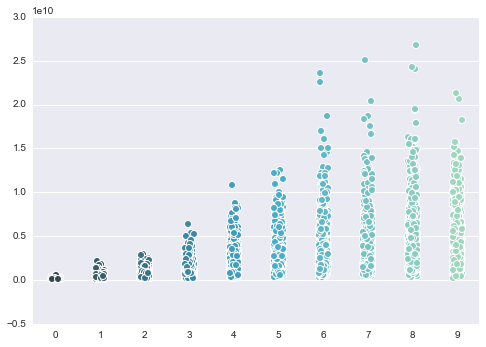

In [8]:
# Take a look at total cost distribution
sns.stripplot(data=columnData['Cost'], palette='GnBu_d',jitter=True)

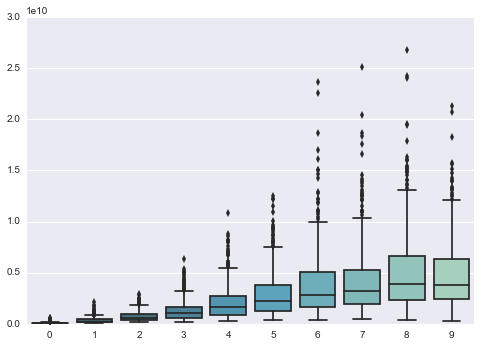

In [9]:
# Alternative visualization with a boxplot
BoxPlot = sns.boxplot(data=columnData['Cost'], palette='GnBu_d')

In [10]:
# Want to look at distribution of destroyed equipment, so pull the status data
statuses = DataFrame(columnData['Status']).transpose()
new_col_names = []
for j in range(0,statuses.shape[1]): #iterate over columns
    new_col_names.append('Status ' + str(j+1))
statuses.columns = new_col_names

In [11]:
statuses.head()

,Status 1,Status 2,Status 3,Status 4,Status 5,Status 6,Status 7,Status 8,Status 9,Status 10
0,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Destroyed
1,Exists,Exists,Exists,Exists,Exists,Destroyed,Exists,Exists,Destroyed,Exists
2,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Destroyed,Exists,Destroyed
3,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Destroyed
4,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Exists,Destroyed,Destroyed


In [12]:
# Create a df with value counts
status_df = []
for j in range(0,statuses.shape[1]):
    status_df.append(statuses['Status ' + str(j+1)].value_counts())
status_df = DataFrame(status_df).transpose()
status_df.fillna(0)

,0,1,2,3,4,5,6,7,8,9
Destroyed,0,0,0,0,0,30,75,174,234,341
Exists,500,500,500,500,500,470,425,326,266,159


In [13]:
# Rename for clarity in new df
new_col_names = []
for j in range(0,status_df.shape[1]): #iterate over columns
    new_col_names.append(str(j+1) + ' stars')
status_df.columns = new_col_names

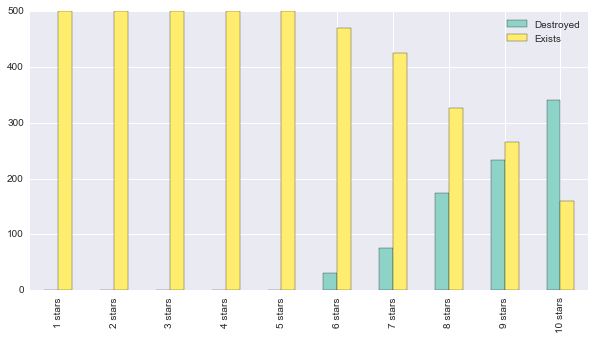

In [14]:
status_df.transpose().plot(kind='bar',figsize=(10,5),cmap='Set3')